# Time profile co-clustering

The current notebook has been run on a MacBook Pro with 2.3 GHz Quad-Core Intel Core i5 processor and 16 GB RAM. 

In [1]:
import cgc
import dask.array as da
import numpy as np
import os
import time

from dask.distributed import Client, LocalCluster

from cgc.coclustering import Coclustering

In [2]:
print(cgc.__version__)

0.6.1


In [3]:
# disable numpy threading
os.environ["OMP_NUM_THREADS"] = "1"  
os.environ["OPENBLAS_NUM_THREADS"] = "1"  
os.environ["MKL_NUM_THREADS"] = "1" 

In [4]:
def time_function(f, *args, **kwargs):
    """Execute function f and return timing."""
    start = time.time()
    _ = f(*args, **kwargs)
    return time.time() - start

In [5]:
# start local Dask cluster
cluster = LocalCluster(processes=False, n_workers=4, threads_per_worker=1, memory_limit=False)
client = Client(cluster)

In [6]:
# one call to low-memory algorithm to Numba JIT compile
_ = Coclustering(np.random.random((5,5)), 2, 2).run_with_threads(nthreads=1, low_memory=True)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Time vs number of rows

In [7]:
# calculation parameters
ms = [300, 3_000, 30_000, 300_000, 3_000_000]  # num rows
n = 300  # num columns
k = 5  # num row clusters
l = 5  # num col clusters

In [8]:
time_vs_rows = {key: np.zeros(len(ms)) for key in ("numpy", "numpy-low-mem", "dask")}

In [9]:
# Numpy-based implementation
for i, mi in enumerate(ms):
    cc = Coclustering(np.random.random((mi, n)), k,  l)
    time_vs_rows["numpy"][i] = time_function(
        cc.run_with_threads, nthreads=1
    )
    del cc

In [10]:
# Numpy-based implementation, low-memory algorithm
for i, mi in enumerate(ms):
    cc = Coclustering(np.random.random((mi, n)), k,  l)
    time_vs_rows["numpy-low-mem"][i] = time_function(
        cc.run_with_threads, nthreads=1, low_memory=True
    )
    del cc

In [11]:
# Dask-based implementation
for i, mi in enumerate(ms):
    Z = da.random.random((mi, n), chunks=(50000, 300))
    cc = Coclustering(Z, k,  l)
    time_vs_rows["dask"][i] = time_function(
        cc.run_with_dask, client=client
    )
    del Z, cc

## Time vs number of row clusters

In [12]:
# calculation parameters
m = 300_000  # num rows
n = 300  # num columns
ks = [5, 10, 50, 100, 500]  # num row clusters
l = 5  # num col clusters

In [13]:
time_vs_rowcls = {key: np.zeros(len(ks)) for key in ("numpy", "numpy-low-mem", "dask")}

In [14]:
# Numpy-based implementation
for i, ki in enumerate(ks):
    cc = Coclustering(np.random.random((m, n)), ki,  l)
    time_vs_rowcls["numpy"][i] = time_function(
        cc.run_with_threads, nthreads=1
    )
    del cc

In [15]:
# Numpy-based implementation, low-memory algorithm
for i, ki in enumerate(ks):
    cc = Coclustering(np.random.random((m, n)), ki,  l)
    time_vs_rowcls["numpy-low-mem"][i] = time_function(
        cc.run_with_threads, nthreads=1, low_memory=True
    )
    del cc

In [16]:
# Dask-based implementation
for i, ki in enumerate(ks):
    Z = da.random.random((m, n), chunks=(50000, 300))
    cc = Coclustering(Z, ki,  l)
    time_vs_rowcls["dask"][i] = time_function(
        cc.run_with_dask, client=client
    )
    del Z, cc

## Plot

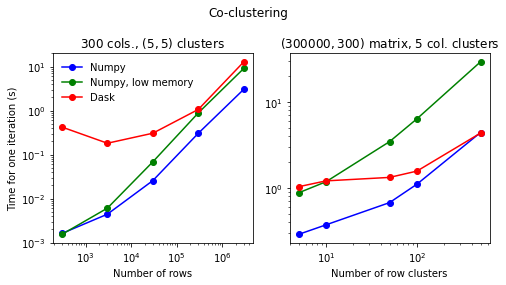

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(7, 4))

fig.suptitle("Co-clustering")

ax[0].plot(ms, time_vs_rows["numpy"], marker="o", label="Numpy", color="b")
ax[0].plot(ms, time_vs_rows["numpy-low-mem"], marker="o", label="Numpy, low memory", color="g")
ax[0].plot(ms, time_vs_rows["dask"], marker="o", label="Dask", color="r")
ax[0].set_ylabel("Time for one iteration (s)")
ax[0].set_xlabel("Number of rows")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_title(f"{n} cols., $({k}, {l})$ clusters")
ax[0].legend(frameon=False)

ax[1].plot(ks, time_vs_rowcls["numpy"], marker="o", label="Numpy", color="b")
ax[1].plot(ks, time_vs_rowcls["numpy-low-mem"], marker="o", label="Numpy, low memory", color="g")
ax[1].plot(ks, time_vs_rowcls["dask"], marker="o", label="Dask", color="r")
ax[1].set_xlabel("Number of row clusters")
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_title(f"$({m}, {n})$ matrix, {l} col. clusters")

plt.tight_layout()
plt.savefig("time_profile_coclustering.png", dpi=150)